
# Question 2. Build regression models to predict movie revenue and vote averages.

In [ ]:
#get java and spark
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget	-q	https://archive.apache.org/dist/spark/spark-3.0.0/spark-3.0.0-bin-hadoop3.2.tgz

# unzip 
!tar xf spark-3.0.0-bin-hadoop3.2.tgz

# set your spark folder to your system path environment 
import os

os.environ["JAVA_HOME"]	= "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"]	= "/content/spark-3.0.0-bin-hadoop3.2"

!pip install -q findspark

import findspark 
findspark.init()

from pyspark.sql import SparkSession

spark = SparkSession.builder.master("local[*]").getOrCreate()

spark.version

'3.0.0'


## Reading the data

▶ movies_metadata.csv: The main Movies Metadata file.
Contains information on 45,000 movies featured in the Full
MovieLens dataset. Features include posters, backdrops,
budget, revenue, release dates, languages, production countries
and companies.

▶ keywords.csv: Contains the movie plot keywords for our
MovieLens movies. Available in the form of a stringified JSON
Object.

▶ credits.csv: Consists of Cast and Crew Information for all our
movies. Available in the form of a JSON Object.

▶ links.csv: The file that contains the TMDB and IMDB IDs of
all the movies featured in the Full MovieLens dataset.

▶ ratings.csv: This file contains 26 million ratings from 270,000
users for all 45,000 movies. Ratings are on a scale of 1-5 and
have been obtained from the official GroupLens website.



In [ ]:
# load dfs
from google.colab import drive
drive.mount('/content/drive');

# metadata = spark.read.option("header","true").csv('/content/drive/MyDrive/Colab Notebooks/archive/movies_metadata.csv')
# keywords = spark.read.option("header","true").csv('/content/drive/MyDrive/Colab Notebooks/archive/keywords.csv')
# credits = spark.read.option("header","true").csv('/content/drive/MyDrive/Colab Notebooks/archive/credits.csv')
# links = spark.read.option("header","true").csv('/content/drive/MyDrive/Colab Notebooks/archive/links.csv')
# ratings = spark.read.option("header","true").csv('/content/drive/MyDrive/Colab Notebooks/archive/ratings.csv')

links=spark.read\
.format("com.databricks.spark.csv")\
.option("multiline",True)\
.option("header",True)\
.option("escape", "\"")\
.option("inferschema",True)\
.csv("/content/drive/MyDrive/Colab Notebooks/archive/links.csv")

keywords=spark.read\
.format("com.databricks.spark.csv")\
.option("multiline",True)\
.option("header",True)\
.option("escape", "\"")\
.option("inferschema",True)\
.csv("/content/drive/MyDrive/Colab Notebooks/archive/keywords.csv")

metadata=spark.read\
.format("com.databricks.spark.csv")\
.option("multiline",True)\
.option("header",True)\
.option("escape", "\"")\
.option("inferschema",True)\
.csv("/content/drive/MyDrive/Colab Notebooks/archive/movies_metadata.csv")

credits=spark.read\
.format("com.databricks.spark.csv")\
.option("multiline",True)\
.option("header",True)\
.option("escape", "\"")\
.option("inferschema",True)\
.csv("/content/drive/MyDrive/Colab Notebooks/archive/credits.csv")

ratings=spark.read\
.format("com.databricks.spark.csv")\
.option("multiline",True)\
.option("header",True)\
.option("escape", "\"")\
.option("inferschema",True)\
.csv("/content/drive/MyDrive/Colab Notebooks/archive/ratings.csv")

# This file will be used for generating recommendation. This is of samller size to help support processing capabilities
ratings_sample=spark.read\
.format("com.databricks.spark.csv")\
.option("multiline",True)\
.option("header",True)\
.option("escape", "\"")\
.option("inferschema",True)\
.csv("/content/drive/MyDrive/Colab Notebooks/archive/ratings_small.csv")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


.

## Some data cleaning

I drop rows with null values in "production_countries" and "genres" as i think that those columns are mandatory for machine learning.

In [ ]:
# handling nans

print((metadata.count(), len(metadata.columns)))
metadata = metadata.na.drop(subset=["production_countries","genres"])
print((metadata.count(), len(metadata.columns)))

(45466, 24)
(45463, 24)


In [ ]:
from pyspark.sql.functions import col

# drop corrupted records mentioned in a kaggle forum conversation

metadata=metadata.where(~col('id').isin('82663','162372','215848'))
print((metadata.count(), len(metadata.columns)))

(45461, 24)


In [ ]:
from pyspark.sql.functions import when, col, isnan, from_json, explode, split, regexp_replace, regexp_extract

# formating genres and production_countries columns
metadata=metadata.withColumn('genres',when(col('genres')=='[]',"[{'id': 0, 'name': 'Unknown'}]").otherwise(col('genres')))\
               .withColumn('production_countries',when(col('production_countries')=='[]',"[{'iso_3166_1': 'Unknown', 'name': 'Unknown'}]") \
                           .otherwise(col('production_countries')))


In [ ]:
# change some data types

metadata=metadata.withColumn('budget',col('budget').cast('integer'))\
                               .withColumn('popularity',col('popularity').cast('float'))\
                               .withColumn('revenue',col('revenue').cast('integer'))

In [ ]:
# drop duplicates on imdb_id which should be unique

metadata = metadata.drop_duplicates(['imdb_id'])
print((metadata.count(), len(metadata.columns)))

(45413, 24)



## Processing metadata dataframe for machine learning



The belongs_to_collection column as a lot of missing values (about 90%) and the data inside doesn't seem so intersting for the tasks at hand. I will drop along with the tagline and homepage columns (more than 50% missings and data not mandatory). Overwiew column will require a lot of NLP processing which is outside of the scope of this course. Some columns have only a unique value, thus they are useless for analysis. Also, drop some redondant columns.

In [ ]:
to_drop = ("belongs_to_collection","tagline", "homepage", "production_companies", "spoken_languages", "video",
           "original_title", "imdb_id", "adult", "overview", "poster_path", "status")
metadata_ml = metadata.drop(*to_drop)
metadata_ml.printSchema()

root
 |-- budget: integer (nullable = true)
 |-- genres: string (nullable = true)
 |-- id: string (nullable = true)
 |-- original_language: string (nullable = true)
 |-- popularity: float (nullable = true)
 |-- production_countries: string (nullable = true)
 |-- release_date: string (nullable = true)
 |-- revenue: integer (nullable = true)
 |-- runtime: double (nullable = true)
 |-- title: string (nullable = true)
 |-- vote_average: double (nullable = true)
 |-- vote_count: integer (nullable = true)



Now let's handle the nans.

In [ ]:
# Number of missing values for each dataframe and column
from pyspark.sql.functions import col,isnan, when, count

def nb_nans(df):
  df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

nb_nans(metadata_ml)

+------+------+---+-----------------+----------+--------------------+------------+-------+-------+-----+------------+----------+
|budget|genres| id|original_language|popularity|production_countries|release_date|revenue|runtime|title|vote_average|vote_count|
+------+------+---+-----------------+----------+--------------------+------------+-------+-------+-----+------------+----------+
|     1|     0|  0|               11|         1|                   0|          81|      1|    256|    1|           1|         1|
+------+------+---+-----------------+----------+--------------------+------------+-------+-------+-----+------------+----------+



In [ ]:
print((metadata_ml.count(), len(metadata_ml.columns)))
metadata_ml = metadata_ml.na.drop()
print((metadata_ml.count(), len(metadata_ml.columns)))

(45413, 12)
(45076, 12)


We can see that we have some columns that are in a hashmap format, this is problematic for analysis and modelling. We have to fix this.

Hashmap columns: 
* production_countries
* genres

In [ ]:
metadata_ml.select(["genres", "production_countries"]).show(5, truncate=False)

+---------------------------------------------------------------+----------------------------------------------------------+
|genres                                                         |production_countries                                      |
+---------------------------------------------------------------+----------------------------------------------------------+
|[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'name': 'Drama'}]    |[{'iso_3166_1': 'US', 'name': 'United States of America'}]|
|[{'id': 35, 'name': 'Comedy'}, {'id': 27, 'name': 'Horror'}]   |[{'iso_3166_1': 'US', 'name': 'United States of America'}]|
|[{'id': 18, 'name': 'Drama'}, {'id': 80, 'name': 'Crime'}]     |[{'iso_3166_1': 'US', 'name': 'United States of America'}]|
|[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'name': 'Romance'}]|[{'iso_3166_1': 'US', 'name': 'United States of America'}]|
|[{'id': 18, 'name': 'Drama'}]                                  |[{'iso_3166_1': 'US', 'name': 'United States of America'}]|


In [ ]:
from pyspark.sql.functions import count, when, col, isnan, from_json, explode, map_keys, udf, coalesce, lit, to_date, year, split ,get_json_object, array, collect_list, concat_ws, regexp_replace, regexp_extract
from pyspark.sql.types import StructType, StringType, IntegerType, MapType, ArrayType, StructField


# Define the schemas of json array type for the columns production_ and genres
schema = ArrayType(
    StructType([
        StructField('id', StringType(), nullable=False), 
        StructField('name', StringType(), nullable=False)
    ]))

# Create a user define function to convert list to column separated values. 
# Indeed, extracting values based on json keys will produce lists
convertList = udf(lambda s: '; '.join(map(str, s)), StringType())


# Apply json parsing to metadata df columns 
metadata_ml = metadata_ml.withColumn("genres_", convertList(from_json(metadata_ml.genres, schema).getField("name"))) \
          .withColumn("production_countries_", when(col("production_countries")=='[]', '') \
                      .otherwise(convertList(from_json(metadata_ml.production_countries, schema).getField("name"))))

# Drop columns that are now useless
to_drop = ("genres", "production_countries")
metadata_ml = metadata_ml.drop(*to_drop)

print((metadata_ml.count(), len(metadata_ml.columns)))
metadata_ml.show(5, truncate=False)

(45076, 12)
+------+------+-----------------+----------+------------+-------+-------+--------------------------+------------+----------+--------------+------------------------+
|budget|id    |original_language|popularity|release_date|revenue|runtime|title                     |vote_average|vote_count|genres_       |production_countries_   |
+------+------+-----------------+----------+------------+-------+-------+--------------------------+------------+----------+--------------+------------------------+
|0     |151831|en               |0.079384  |1919-05-01  |0      |55.0   |The Delicious Little Devil|5.0         |1         |Comedy; Drama |United States of America|
|0     |51359 |en               |0.325674  |1921-02-21  |0      |21.0   |The Haunted House         |6.5         |16        |Comedy; Horror|United States of America|
|0     |42565 |xx               |0.857462  |1927-08-20  |0      |87.0   |Underworld                |7.4         |8         |Drama; Crime  |United States of America

Some formatting of the new columns to make them ready for machine learning.

In [ ]:
# new genre cols
split_col = split(metadata_ml['genres_'], ';')
metadata_ml = metadata_ml.withColumn('genre_1', split_col.getItem(0)) \
  .withColumn('genre_2', split_col.getItem(1)) \
  .withColumn('genre_3', split_col.getItem(2)) \
  .withColumn('genre_4', split_col.getItem(3))

# new production_countries cols
split_col = split(metadata_ml['production_countries_'], ';') 
metadata_ml = metadata_ml.withColumn('production_country_1', split_col.getItem(0)) \
  .withColumn('production_country_2', split_col.getItem(1))

# drop columns that are now useless
to_drop = ("genres_", "production_countries_")
metadata_ml = metadata_ml.drop(*to_drop) 
print((metadata_ml.count(), len(metadata_ml.columns))) 
metadata_ml.show(5, truncate=False)

(45076, 16)
+------+------+-----------------+----------+------------+-------+-------+--------------------------+------------+----------+-------+--------+-------+-------+------------------------+--------------------+
|budget|id    |original_language|popularity|release_date|revenue|runtime|title                     |vote_average|vote_count|genre_1|genre_2 |genre_3|genre_4|production_country_1    |production_country_2|
+------+------+-----------------+----------+------------+-------+-------+--------------------------+------------+----------+-------+--------+-------+-------+------------------------+--------------------+
|0     |151831|en               |0.079384  |1919-05-01  |0      |55.0   |The Delicious Little Devil|5.0         |1         |Comedy | Drama  |null   |null   |United States of America|null                |
|0     |51359 |en               |0.325674  |1921-02-21  |0      |21.0   |The Haunted House         |6.5         |16        |Comedy | Horror |null   |null   |United States o

In [ ]:
# convert release date to movie age 
from pyspark.sql.functions import current_date, datediff, col

# Assume you have a DataFrame df with a date column 'birthdate'
metadata_ml = metadata_ml.withColumn("age", datediff(current_date(), col("release_date"))/365)
metadata_ml = metadata_ml.withColumn("age", metadata_ml.age.cast('int'))

In [ ]:
# drop release date column
metadata_ml = metadata_ml.drop("release_date")
print((metadata_ml.count(), len(metadata_ml.columns)))
metadata_ml.show(5, truncate=False)

(45076, 16)
+------+------+-----------------+----------+-------+-------+--------------------------+------------+----------+-------+--------+-------+-------+------------------------+--------------------+---+
|budget|id    |original_language|popularity|revenue|runtime|title                     |vote_average|vote_count|genre_1|genre_2 |genre_3|genre_4|production_country_1    |production_country_2|age|
+------+------+-----------------+----------+-------+-------+--------------------------+------------+----------+-------+--------+-------+-------+------------------------+--------------------+---+
|0     |151831|en               |0.079384  |0      |55.0   |The Delicious Little Devil|5.0         |1         |Comedy | Drama  |null   |null   |United States of America|null                |103|
|0     |51359 |en               |0.325674  |0      |21.0   |The Haunted House         |6.5         |16        |Comedy | Horror |null   |null   |United States of America|null                |101|
|0     |42565

## Processing Credits dataset for ML

This dataset might also contain useful information for machine learning.

In [ ]:
credits.show(5, truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
# column 'cast' has values in Json string array
# schema definition does not recognize key if None

def parse_cast(value):
  '''
  Parse the profile_path column
  '''
  value = value.replace("'profile_path': None", "'profile_path': null")
  return value

convertCast= udf(lambda x: parse_cast(x)) 

# Define the schemas of json array type for the columns of interest
schema=ArrayType(StructType([
  StructField('cast_id',IntegerType(),nullable=True),
  StructField('character',StringType(),nullable=True),
  StructField('credit_id',StringType(),nullable=True),
  StructField('gender',IntegerType(),nullable=True),
  StructField('id',IntegerType(),nullable=True),
  StructField('name',StringType(),nullable=True),
  StructField('order',IntegerType(),nullable=True),
  StructField('profile_path',StringType(),nullable=True)
]))


#apply transformations to cast column
credits_ml = credits.withColumn("cast", convertCast(col("cast")))
credits_ml = credits_ml.withColumn('actors',from_json(col('cast'), schema).getField("name").alias('actors'))\
        .withColumn('director',regexp_extract(col('crew'),"(.)('job': 'Director', 'name': ')((\w+)(\s+)(\w+))(')",3))

credits_ml.select(["id", "actors", "director"]).show(5)

+-----+--------------------+---------------+
|   id|              actors|       director|
+-----+--------------------+---------------+
|  862|[Tom Hanks, Tim A...|  John Lasseter|
| 8844|[Robin Williams, ...|   Joe Johnston|
|15602|[Walter Matthau, ...|  Howard Deutch|
|31357|[Whitney Houston,...|Forest Whitaker|
|11862|[Steve Martin, Di...|  Charles Shyer|
+-----+--------------------+---------------+
only showing top 5 rows



In [ ]:
# new actors / directors cols
credits_ml = credits_ml.select(["id", "actors", "director"])

split_col = credits_ml['actors']
credits_ml = credits_ml.withColumn('actor_1', split_col.getItem(0)) \
  .withColumn('actor_2', split_col.getItem(1)) \
  .withColumn('actor_3', split_col.getItem(2)) \
  .withColumn('actor_4', split_col.getItem(2)) 
  
credits_ml = credits_ml.select(["id", "director", 'actor_1', 'actor_2', 'actor_3'])
credits_ml.show(5)

+-----+---------------+---------------+--------------+--------------+
|   id|       director|        actor_1|       actor_2|       actor_3|
+-----+---------------+---------------+--------------+--------------+
|  862|  John Lasseter|      Tom Hanks|     Tim Allen|   Don Rickles|
| 8844|   Joe Johnston| Robin Williams| Jonathan Hyde| Kirsten Dunst|
|15602|  Howard Deutch| Walter Matthau|   Jack Lemmon|   Ann-Margret|
|31357|Forest Whitaker|Whitney Houston|Angela Bassett|Loretta Devine|
|11862|  Charles Shyer|   Steve Martin|  Diane Keaton|  Martin Short|
+-----+---------------+---------------+--------------+--------------+
only showing top 5 rows



## Building the machine learning dataset by joining original dfs

In [ ]:
credits_ml = credits_ml.withColumn("creditsId",col("id").cast(StringType())).drop('id')

In [ ]:
df = metadata_ml.join(credits_ml, metadata_ml.id==credits_ml.creditsId, how='inner')

In [ ]:
print((df.count(), len(df.columns)))
df.show(5, truncate=False)

(45119, 21)
+--------+------+-----------------+----------+--------+-------+--------------------+------------+----------+--------+---------+--------+-------+------------------------+--------------------+---+---------------+----------------+-----------------+--------------+---------+
|budget  |id    |original_language|popularity|revenue |runtime|title               |vote_average|vote_count|genre_1 |genre_2  |genre_3 |genre_4|production_country_1    |production_country_2|age|director       |actor_1         |actor_2          |actor_3       |creditsId|
+--------+------+-----------------+----------+--------+-------+--------------------+------------+----------+--------+---------+--------+-------+------------------------+--------------------+---+---------------+----------------+-----------------+--------------+---------+
|0       |100010|en               |0.769266  |0       |116.0  |Flight Command      |6.0         |1         |Drama   | War     |null    |null   |United States of America|null  

In [ ]:
df.toPandas().to_csv("/content/drive/MyDrive/Colab Notebooks/archive/cleaned_df.csv", index=False, sep=",")

## Build regression models to predict movie revenue and vote averages.

In [ ]:
df = spark.read.options(multiline="True", header="True", inferSchema="True", delimiter=',', escape="\"") \
                      .csv("/content/drive/MyDrive/Colab Notebooks/archive/cleaned_df.csv")

print((df.count(), len(df.columns)))
df.show(5, truncate=False)

(45119, 21)
+--------+------+-----------------+----------+--------+-------+--------------------+------------+----------+--------+---------+--------+-------+------------------------+--------------------+---+---------------+----------------+-----------------+--------------+---------+
|budget  |id    |original_language|popularity|revenue |runtime|title               |vote_average|vote_count|genre_1 |genre_2  |genre_3 |genre_4|production_country_1    |production_country_2|age|director       |actor_1         |actor_2          |actor_3       |creditsId|
+--------+------+-----------------+----------+--------+-------+--------------------+------------+----------+--------+---------+--------+-------+------------------------+--------------------+---+---------------+----------------+-----------------+--------------+---------+
|0       |100010|en               |0.769266  |0       |116.0  |Flight Command      |6.0         |1         |Drama   | War     |null    |null   |United States of America|null  

### 2.1 To predict vote_average

#### Separating categorical from numerical columns

In [ ]:
# drop useless cols for machine learning 

df = df.drop('id', 'creditsId', 'title')
print((df.count(), len(df.columns)))
df.printSchema()

(45119, 18)
root
 |-- budget: integer (nullable = true)
 |-- original_language: string (nullable = true)
 |-- popularity: double (nullable = true)
 |-- revenue: integer (nullable = true)
 |-- runtime: double (nullable = true)
 |-- vote_average: double (nullable = true)
 |-- vote_count: integer (nullable = true)
 |-- genre_1: string (nullable = true)
 |-- genre_2: string (nullable = true)
 |-- genre_3: string (nullable = true)
 |-- genre_4: string (nullable = true)
 |-- production_country_1: string (nullable = true)
 |-- production_country_2: string (nullable = true)
 |-- age: integer (nullable = true)
 |-- director: string (nullable = true)
 |-- actor_1: string (nullable = true)
 |-- actor_2: string (nullable = true)
 |-- actor_3: string (nullable = true)



In [ ]:
from pyspark.sql.functions import col, countDistinct

# checking the number of categories
cat_cols = [item[0] for item in df.dtypes if item[1].startswith('string')]
df.agg(*(countDistinct(col(c)).alias(c) for c in cat_cols)).show()

+-----------------+-------+-------+-------+-------+--------------------+--------------------+--------+-------+-------+-------+
|original_language|genre_1|genre_2|genre_3|genre_4|production_country_1|production_country_2|director|actor_1|actor_2|actor_3|
+-----------------+-------+-------+-------+-------+--------------------+--------------------+--------+-------+-------+-------+
|               89|     21|     20|     20|     20|                 144|                 130|   13953|  18250|  22234|  24346|
+-----------------+-------+-------+-------+-------+--------------------+--------------------+--------+-------+-------+-------+



This time we choose to drop variables with to much categories because in pyspark binary, hash or target encoding are not yet implemented one hot encoding would create a huge matrix of 100000 cols and StringIndexer generate an error because of too many categories.

In [ ]:
df = df.drop('director', 'actor_1', 'actor_2', 'actor_3')

In [ ]:
# usefull later

cat_cols = [item[0] for item in df.dtypes if item[1].startswith('string')]
num_cols = [item[0] for item in df.dtypes if item[0] not in cat_cols]
num_cols

['budget',
 'popularity',
 'revenue',
 'runtime',
 'vote_average',
 'vote_count',
 'age']

In [ ]:
from pyspark.sql.functions import col

for col_name in num_cols:
    df = df.withColumn(col_name, col(col_name).cast('float'))

#### Handling Null Values


In [ ]:
# Number of missing values for each dataframe and column
from pyspark.sql.functions import col,isnan, when, count

def nb_nans(df):
  df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

nb_nans(df)

+------+-----------------+----------+-------+-------+------------+----------+-------+-------+-------+-------+--------------------+--------------------+---+
|budget|original_language|popularity|revenue|runtime|vote_average|vote_count|genre_1|genre_2|genre_3|genre_4|production_country_1|production_country_2|age|
+------+-----------------+----------+-------+-------+------------+----------+-------+-------+-------+-------+--------------------+--------------------+---+
|     0|                0|         0|      0|      0|           0|         0|      0|  16731|  31171|  40725|                   0|               38109|  0|
+------+-----------------+----------+-------+-------+------------+----------+-------+-------+-------+-------+--------------------+--------------------+---+



In [ ]:
# there is only missing values in categorical variables 
df = df.fillna(value='Missing')
df.show(5)

+---------+-----------------+----------+-----------+-------+------------+----------+--------+---------+--------+-------+--------------------+--------------------+----+
|   budget|original_language|popularity|    revenue|runtime|vote_average|vote_count| genre_1|  genre_2| genre_3|genre_4|production_country_1|production_country_2| age|
+---------+-----------------+----------+-----------+-------+------------+----------+--------+---------+--------+-------+--------------------+--------------------+----+
|      0.0|               en|  0.769266|        0.0|  116.0|         6.0|       1.0|   Drama|      War| Missing|Missing|United States of ...|             Missing|82.0|
|    3.7E7|               en| 12.632595|9.6455696E7|   98.0|         6.3|    1260.0|  Comedy|  Fantasy| Romance|Missing|United States of ...|             Missing|18.0|
|      0.0|               en|  0.109861|        0.0|   74.0|         5.2|       3.0|TV Movie| Thriller|   Crime|  Drama|United States of ...|             Missin

#### Handling Categorical Variables and fitting the model


In [ ]:
from pyspark.sql.functions import col, countDistinct

# checking the number of categories
df.agg(*(countDistinct(col(c)).alias(c) for c in cat_cols)).show()

+-----------------+-------+-------+-------+-------+--------------------+--------------------+
|original_language|genre_1|genre_2|genre_3|genre_4|production_country_1|production_country_2|
+-----------------+-------+-------+-------+-------+--------------------+--------------------+
|               89|     21|     21|     21|     21|                 144|                 131|
+-----------------+-------+-------+-------+-------+--------------------+--------------------+



In [ ]:
num_cols.remove('vote_average')
num_cols

['budget', 'popularity', 'revenue', 'runtime', 'vote_count', 'age']

In [ ]:
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml import Pipeline


# Create a StringIndexer for each categorical column
indexers = [StringIndexer(inputCol=c, outputCol="{0}_indexed".format(c)).setHandleInvalid("keep") for c in cat_cols]

# Create a VectorAssembler to combine the numerical and indexed categorical columns
indexed_categorical_cols = [col + "_indexed" for col in cat_cols]
assembler = VectorAssembler(inputCols=num_cols+indexed_categorical_cols, outputCol="features")

# Create a RandomForestRegressor
rf = RandomForestRegressor(labelCol="vote_average", featuresCol="features", maxBins=150)

# Create a pipeline
pipeline = Pipeline(stages=indexers+[assembler, rf])

# Split the data into training and test sets (20% held out for testing)
(trainingData, testData) = df.randomSplit([0.8, 0.2])

# Fit the pipeline on the data
model = pipeline.fit(trainingData)



In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator

# Make predictions.
predictions = model.transform(testData)

# Select example rows to display.
predictions.show(5)

# Select (prediction, true label) and compute test error
evaluator = RegressionEvaluator(labelCol="vote_average", predictionCol="prediction", metricName="rmse")

# Root Mean Square Error
rmse = evaluator.evaluate(predictions) 
print('RMSE: %.3f' % rmse)

# Mean Square Error
mse = evaluator.evaluate(predictions, {evaluator.metricName: 'mse'}) 
print('MSE: %.3f' % mse)

# Mean Absolute Error
mae = evaluator.evaluate(predictions, {evaluator.metricName: 'mae'}) 
print('MAE: %.3f' % mae)

# r2 - coefficient of determination
r2 = evaluator.evaluate(predictions, {evaluator.metricName: 'r2'}) 
print('r2: %.3f' %r2)

+------+-----------------+----------+-------+-------+------------+----------+---------+----------+-------+----------------+--------------------+--------------------+----+-------------------------+---------------+---------------+---------------+---------------+----------------------------+----------------------------+--------------------+-----------------+
|budget|original_language|popularity|revenue|runtime|vote_average|vote_count|  genre_1|   genre_2|genre_3|         genre_4|production_country_1|production_country_2| age|original_language_indexed|genre_1_indexed|genre_2_indexed|genre_3_indexed|genre_4_indexed|production_country_1_indexed|production_country_2_indexed|            features|       prediction|
+------+-----------------+----------+-------+-------+------------+----------+---------+----------+-------+----------------+--------------------+--------------------+----+-------------------------+---------------+---------------+---------------+---------------+------------------------

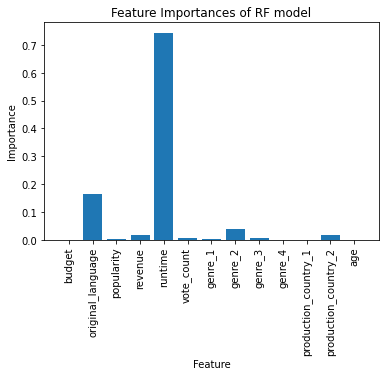

In [ ]:
import matplotlib.pyplot as plt

# Extract the model from the pipeline
rfModel = model.stages[8]

# Get feature importances
importances = rfModel.featureImportances

# Create a list of feature names
feature_names = trainingData.columns
feature_names.remove('vote_average')

# Create a bar chart of feature importances
plt.bar(feature_names, importances)
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.xticks(rotation=90)
plt.title("Feature Importances of RF model")
plt.show()


### 2.2 To predict revenue


In [ ]:
num_cols = [item[0] for item in df.dtypes if item[0] not in cat_cols]
num_cols.remove('revenue')
num_cols

['budget', 'popularity', 'runtime', 'vote_average', 'vote_count', 'age']

In [ ]:
from pyspark.sql.functions import col

# Remove rows where revenue (target) is <= 0
df_filtered = df.filter(col("revenue") > 0)

print((df_filtered.count(), len(df_filtered.columns)))
df_filtered.show(5, truncate=False)

(7400, 14)
+---------+-----------------+----------+-----------+-------+------------+----------+--------+----------------+--------+---------+------------------------+--------------------+----+
|budget   |original_language|popularity|revenue    |runtime|vote_average|vote_count|genre_1 |genre_2         |genre_3 |genre_4  |production_country_1    |production_country_2|age |
+---------+-----------------+----------+-----------+-------+------------+----------+--------+----------------+--------+---------+------------------------+--------------------+----+
|3.7E7    |en               |12.632595 |9.6455696E7|98.0   |6.3         |1260.0    |Comedy  | Fantasy        | Romance|Missing  |United States of America|Missing             |18.0|
|5000000.0|en               |5.215107  |1.5719109E7|90.0   |5.6         |114.0     |Horror  |Missing         |Missing |Missing  |United States of America|Missing             |25.0|
|3.4E7    |en               |8.013617  |3.225544E7 |139.0  |7.0         |172.0     |

In [ ]:
from pyspark.sql.functions import mean, stddev

# Here we remove outliers from the revenue columns in order to get decent predictions
# Calculate mean and standard deviation of the revenue column
col_mean = df.agg(mean(df.revenue)).first()[0]
col_stddev = df.agg(stddev(df.revenue)).first()[0]
print(f'Mean of the revenue column is {col_mean}')
print(f'STD of the revenue column is {col_stddev}')

# Define lower and upper bounds for outliers
lower_bound = col_mean - 3 * col_stddev
upper_bound = col_mean + 3 * col_stddev
print(f'Lower bound is {lower_bound}')
print(f'Upper bound is {upper_bound}')

# Filter out rows that have revenue outside of the bounds
df_filtered = df_filtered.filter((df_filtered.revenue > lower_bound) & (df_filtered.revenue < upper_bound))
print((df_filtered.count(), len(df_filtered.columns)))
df_filtered.show(5, truncate=False)

Mean of the revenue column is 11198793.2043485
STD of the revenue column is 63633038.32037429
Lower bound is -179700321.75677437
Upper bound is 202097908.16547137
(6737, 14)
+---------+-----------------+----------+-----------+-------+------------+----------+--------+----------------+--------+---------+------------------------+--------------------+----+
|budget   |original_language|popularity|revenue    |runtime|vote_average|vote_count|genre_1 |genre_2         |genre_3 |genre_4  |production_country_1    |production_country_2|age |
+---------+-----------------+----------+-----------+-------+------------+----------+--------+----------------+--------+---------+------------------------+--------------------+----+
|3.7E7    |en               |12.632595 |9.6455696E7|98.0   |6.3         |1260.0    |Comedy  | Fantasy        | Romance|Missing  |United States of America|Missing             |18.0|
|5000000.0|en               |5.215107  |1.5719109E7|90.0   |5.6         |114.0     |Horror  |Missing  

In [ ]:
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.regression import GBTRegressor
from pyspark.ml import Pipeline


# Create a StringIndexer for each categorical column
indexers = [StringIndexer(inputCol=c, outputCol="{0}_indexed".format(c)).setHandleInvalid("keep") for c in cat_cols]

# Create a VectorAssembler to combine the numerical and indexed categorical columns
indexed_categorical_cols = [col + "_indexed" for col in cat_cols]
assembler = VectorAssembler(inputCols=num_cols+indexed_categorical_cols, outputCol="features")

# Create a RandomForestRegressor
gbt = GBTRegressor(labelCol="revenue", featuresCol="features", maxBins=150)

# Create a pipeline
pipeline = Pipeline(stages=indexers+[assembler, gbt])

# Split the data into training and test sets (20% held out for testing)
(trainingData, testData) = df_filtered.randomSplit([0.8, 0.2])

# Fit the pipeline on the data
model = pipeline.fit(trainingData)

In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator

# Make predictions.
predictions = model.transform(testData)

# Select example rows to display.
predictions.show(5)

# Select (prediction, true label) and compute test error
evaluator = RegressionEvaluator(labelCol="revenue", predictionCol="prediction", metricName="rmse")

# Root Mean Square Error
rmse = evaluator.evaluate(predictions) 
print('RMSE: %.3f' % rmse)

# Mean Absolute Error
mae = evaluator.evaluate(predictions, {evaluator.metricName: 'mae'}) 
print('MAE: %.3f' % mae)

# r2 - coefficient of determination
r2 = evaluator.evaluate(predictions, {evaluator.metricName: 'r2'}) 
print('r2: %.3f' %r2)

+------+-----------------+----------+---------+-------+------------+----------+-------+----------+-------+-------+--------------------+--------------------+----+-------------------------+---------------+---------------+---------------+---------------+----------------------------+----------------------------+--------------------+-------------------+
|budget|original_language|popularity|  revenue|runtime|vote_average|vote_count|genre_1|   genre_2|genre_3|genre_4|production_country_1|production_country_2| age|original_language_indexed|genre_1_indexed|genre_2_indexed|genre_3_indexed|genre_4_indexed|production_country_1_indexed|production_country_2_indexed|            features|         prediction|
+------+-----------------+----------+---------+-------+------------+----------+-------+----------+-------+-------+--------------------+--------------------+----+-------------------------+---------------+---------------+---------------+---------------+----------------------------+------------------

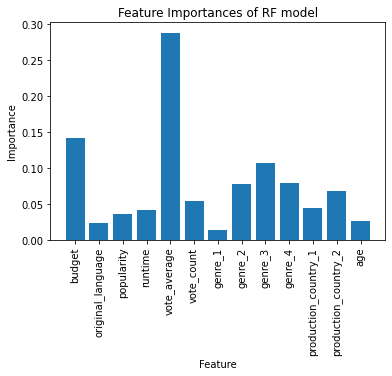

In [ ]:
import matplotlib.pyplot as plt

# Extract the model from the pipeline
rfModel = model.stages[8]

# Get feature importances
importances = rfModel.featureImportances

# Create a list of feature names
feature_names = trainingData.columns
feature_names.remove('revenue')

# Create a bar chart of feature importances
plt.bar(feature_names, importances)
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.xticks(rotation=90)
plt.title("Feature Importances of RF model")
plt.show()
